## Setting Up

In [11]:
from numpy import (
    pi,cos,arange,ones,tile,dot,eye,diag,exp,zeros,sinh,cosh,
    linspace,polyval,polyfit,inf,finfo,set_printoptions,diag,
    sqrt,sin,array,log2
    )
from numpy.linalg import eig, solve, norm
set_printoptions(linewidth=500)
from scipy.interpolate import interp1d

%matplotlib inline

from matplotlib.style import use

use("seaborn")

from pltconfig import *

from matplotlib.pyplot import figure,subplot,plot,title

In [12]:
def cheb(N):
    '''Chebushev polynomial differentiation matrix.
       Ref.: Trefethen's 'Spectral Methods in MATLAB' book.
    '''
    x = cos(pi*arange(0,N+1)/N)
    if (N%2 == 0):
        x[N//2] = 0.0 # only when N is even!
    c = ones(N+1); c[0] = 2.0; c[N] = 2.0
    c = c * (-1.0)**arange(0,N+1)
    c = c.reshape(N+1,1)
    X = tile(x.reshape(N+1,1), (1,N+1))
    dX = X - X.T
    D = dot(c, 1.0/c.T) / (dX+eye(N+1))
    D = D - diag( D.sum(axis=1) )
    return D,x

# Problem 2

## Part A

In [13]:
def construct_D(x, N=None):
    
    if N is None:
        # assume that x is size N+1
        N = x.size-1
        
    assert x.size == N+1, "Sizes do not match"
    
    D = zeros((N+1,N+1))
    
    # this is gross and extremely
    # inefficient
    for i in range(N+1):
        for j in range(N+1):
            
            # compute the a factors
            
            # initialize
            ai = 1.0
            aj = 1.0
            
            # general case
            if (i != j):
                for k in range(N+1):
                    if (k != i): ai *= x[i]-x[k]
                    if (k != j): aj *= x[j]-x[k]
                
                D[i,j] = ai/(aj*(x[i]-x[j]))
                
            # diagonals            
            else:                       
                for k in range(N+1):
                    if (k != j): D[i,j] += 1./(x[j]-x[k]) 
    
    return D

In [14]:
sampleD, sample_X = cheb(4)
sampleD_from_interpolant = construct_D(sample_X)
print(sampleD)
print()
print(sampleD_from_interpolant)

[[ 5.50000000e+00 -6.82842712e+00  2.00000000e+00 -1.17157288e+00  5.00000000e-01]
 [ 1.70710678e+00 -7.07106781e-01 -1.41421356e+00  7.07106781e-01 -2.92893219e-01]
 [-5.00000000e-01  1.41421356e+00  2.22044605e-16 -1.41421356e+00  5.00000000e-01]
 [ 2.92893219e-01 -7.07106781e-01  1.41421356e+00  7.07106781e-01 -1.70710678e+00]
 [-5.00000000e-01  1.17157288e+00 -2.00000000e+00  6.82842712e+00 -5.50000000e+00]]

[[ 5.50000000e+00 -6.82842712e+00  2.00000000e+00 -1.17157288e+00  5.00000000e-01]
 [ 1.70710678e+00 -7.07106781e-01 -1.41421356e+00  7.07106781e-01 -2.92893219e-01]
 [-5.00000000e-01  1.41421356e+00  2.22044605e-16 -1.41421356e+00  5.00000000e-01]
 [ 2.92893219e-01 -7.07106781e-01  1.41421356e+00  7.07106781e-01 -1.70710678e+00]
 [-5.00000000e-01  1.17157288e+00 -2.00000000e+00  6.82842712e+00 -5.50000000e+00]]


## Part B

In [15]:
def gauss(N):
    beta = 0.5/sqrt(1.0-((2.0*arange(1,N))**(-2)))
    T = diag(beta,1) + diag(beta,-1)
    D, V = eig(T)
    idx = D.argsort()
    return D[idx], 2.0*(V[:,idx]**2)

In [16]:
def legendreD(N):
    
    x = zeros(N+1)
    x[0] = -1.0
    x[-1] = 1.0
    
    x[1:-1], __ = gauss(N-1)
    
    D = construct_D(x)
    
    return D, x

## Part C

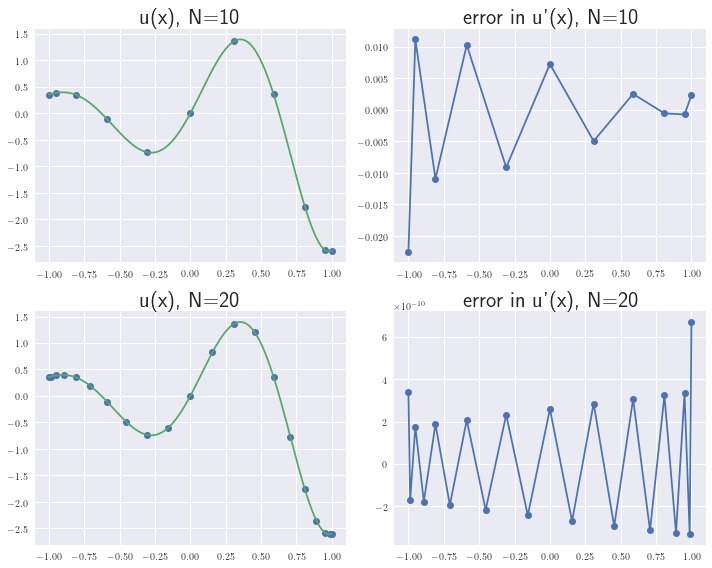

In [17]:
xx = linspace(-1.0,1.0,200,True)
uu = exp(xx)*sin(5.0*xx)
c = 1; fig = figure(figsize=(10,8))
for N in [10,20]:
    D,x = cheb(N); u = exp(x)*sin(5.0*x)
    subplot(2,2,c); c += 1
    plot(x,u,'o',xx,uu)
    title('u(x), N='+str(N), fontsize=22)
    
    error = dot(D,u) - exp(x)*(sin(5.0*x)+5.0*cos(5.0*x))
    subplot(2,2,c); c += 1
    plot(x,error,'o-')
    title('error in u\'(x), N='+str(N), fontsize=22)
fig.tight_layout()
fig.savefig("tchebyshev_err_figure.pdf")

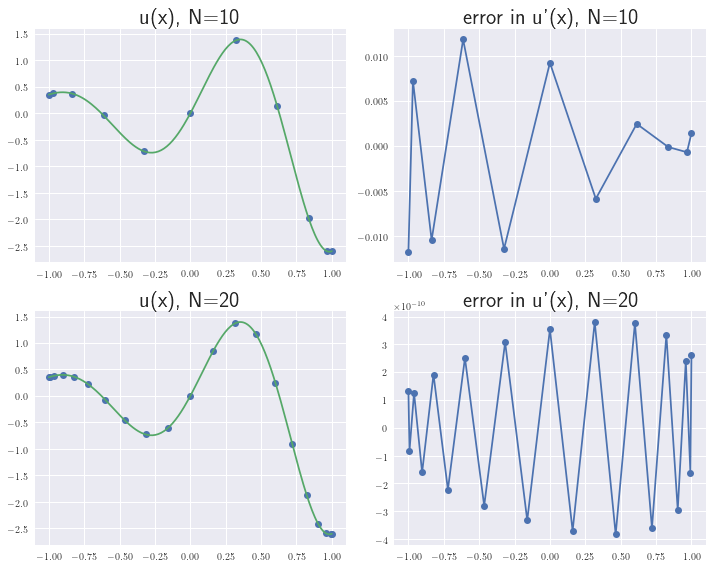

In [18]:
xx = linspace(-1.0,1.0,200,True)
uu = exp(xx)*sin(5.0*xx)
c = 1; fig = figure(figsize=(10,8))
for N in [10,20]:
    D,x = legendreD(N); u = exp(x)*sin(5.0*x)
    subplot(2,2,c); c += 1
    plot(x,u,'o',xx,uu)
    title('u(x), N='+str(N), fontsize=22)
    
    error = dot(D,u) - exp(x)*(sin(5.0*x)+5.0*cos(5.0*x))
    subplot(2,2,c); c += 1
    plot(x,error,'o-')
    title('error in u\'(x), N='+str(N), fontsize=22)

fig.tight_layout()
fig.savefig("legendre_err_figure.pdf")

## Part D

In [19]:
class q2d_1(object):
    
    def __init__(
        self, left=0.0, left_type="dir", 
        right=1.0, right_type="dir", 
        alpha=0.0, beta=0.0, N=16, N_fine=50
        ):
        
        # unload the variables
        self.left = left
        self.left_type = left_type
        self.right = right
        self.right_type = right_type
        self.alpha = alpha
        self.beta = beta
        self.N = N
        self.N_fine = N_fine
        
        # find the transformation that rescales the domain [left, right] to [-1,1]
        self.b, self.m = solve(
            array([[1, self.left],
                   [1, self.right]]), 
            array([-1, 1])
            )
        
        # ========== INITIALIZE LEGENDRE SOLN ===========
        
        # get the LHS matrix and the grid points
        self.A_legendre, self.z_legendre, self.x_legendre = self.get_A_legendre()
        
        # shift the chebyshev grid to be on the correct domain
        self.z = self.z_legendre; self.x = self.x_legendre
        
        # get the RHS vector 
        self.F_legendre = self.get_rhs_legendre()
        
        # compute the solution
        self.F = self.F_legendre; self.A = self.A_legendre
        self.U_legendre = self.compute_soln()
        
        # ========== INITIALIZE TCHEBYSHEV SOLN ===========
        
        # get the LHS matrix and the grid points
        self.A_cheb, self.z_cheb, self.x_cheb = self.get_A_cheb()
        
        # shift the chebyshev grid to be on the correct domain
        self.z = self.z_cheb; self.x = self.x_cheb
        
        # get the RHS vector 
        self.F_cheb = self.get_rhs_cheb()
        
        # compute the solution
        self.F = self.F_cheb; self.A = self.A_cheb
        self.U_cheb = self.compute_soln()
        
    def get_A_legendre(self):
        
        # compute the Chebyshev differentiation matrices and points
        D, z = legendreD(self.N)
        
        x = (1./self.m)*(z-self.b)
        
        D *= self.m # implement rescaling
        
        # define the matrix A with proper rescalings
        A = dot(D,D)
        
        # impose boundary conditions on
        # LHS of the equation
        
        # Left boundary
        if (self.left_type == "dir"):
            A[0,:] = zeros(self.N+1)
            A[0,0] = 1.0
        else:
            A[0,:] = D[0,:]
        
        # Right boundary
        if (self.right_type == "dir"):
            A[-1,:] = zeros(self.N+1)
            A[-1,-1] = 1.0
        else:
            A[-1,:] = D[-1,:] 
        
        return A, z, x
    
    def get_rhs_legendre(self):
        
        F = exp(4*self.x)
        
        # set boundary conditions on the RHS
        
        # left boundary
        F[0] = self.alpha
        
        # right boundary
        F[-1] = self.beta
        
        return F
    
    def get_A_cheb(self):
        
        # compute the Chebyshev differentiation matrices and points
        D, z = cheb(self.N)
        
        x = (1./self.m)*(z-self.b)
        
        D *= self.m
        
        # define the matrix A with proper rescalings
        A = dot(D,D)
        
        # impose boundary conditions on
        # LHS of the equation
        
        # Left boundary
        if (self.left_type == "dir"):
            A[-1,:] = zeros(self.N+1)
            A[-1,-1] = 1.0
        else:
            A[-1,:] = D[-1,:]
        
        # Right boundary
        if (self.right_type == "dir"):
            A[0,:] = zeros(self.N+1)
            A[0,0] = 1.0
        else:
            A[0,:] = D[0,:] 
        
        return A, z, x
    
    def get_rhs_cheb(self):
        
        F = exp(4*self.x)
        
        # set boundary conditions on the RHS
        
        # left boundary
        F[-1] = self.alpha
        
        # right boundary
        F[0] = self.beta
        
        return F
        
    def compute_soln(self):
        return solve(self.A,self.F)
        
    def get_soln_plot(self, save=False):        
        
        fig, ax = subplots(1,1,figsize=(10,10))
        
        xx = linspace(self.left, self.right, self.N_fine)
        
        uu_legendre = polyval(polyfit(self.x_legendre, self.U_legendre, self.x_legendre.size), xx)
        uu_cheb = polyval(polyfit(self.x_cheb, self.U_cheb, self.x_cheb.size), xx)
        ax.plot(xx, uu_cheb, "rs-", lw=3.0, label="TChebyshev soln")
        ax.plot(xx, uu_legendre, "ko--", lw=3.0, label="Legendre soln")
        
        ax.legend(loc=0, prop={"size": 18})
        ax.tick_params(labelsize=18)
        ax.set_ylabel(r"$U(x)$", fontsize=28)
        ax.set_xlabel(r"$x$", fontsize=28)
        
        fig.tight_layout()
        
        if save: fig.savefig("q2d_soln_figure2.pdf")

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RankWarning: Polyfit may be poorly conditioned
  
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RankWarning: Polyfit may be poorly conditioned
  


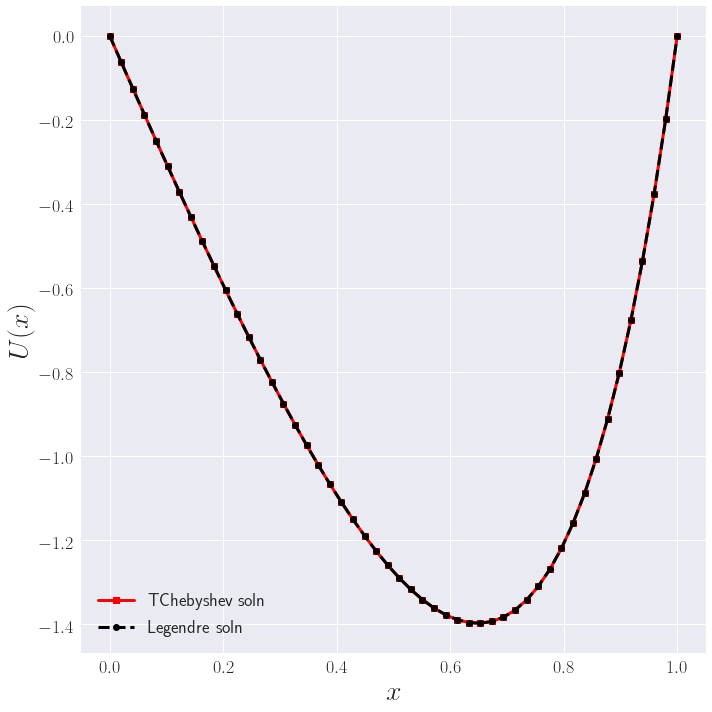

In [20]:
sample_q2d_1 = q2d_1()
sample_q2d_1.get_soln_plot(save=True)

In [21]:
class q2d_2(object):
    
    def __init__(
        self, left=-2.0, left_type="dir", 
        right=1.0, right_type="neu", 
        alpha=0.0, beta=2.0, N=16, N_fine=50
        ):
        
        # unload the variables
        self.left = left
        self.left_type = left_type
        self.right = right
        self.right_type = right_type
        self.alpha = alpha
        self.beta = beta
        self.N = N
        self.N_fine = N_fine
        
        # find the transformation that rescales the domain [left, right] to [-1,1]
        self.b, self.m = solve(
            array([[1, self.left],
                   [1, self.right]]), 
            array([-1, 1])
            )
        
        # ========== INITIALIZE LEGENDRE SOLN ===========
        
        # get the LHS matrix and the grid points
        self.A_legendre, self.z_legendre, self.x_legendre = self.get_A_legendre()
        
        # shift the chebyshev grid to be on the correct domain
        self.z = self.z_legendre; self.x = self.x_legendre
        
        # get the RHS vector 
        self.F_legendre = self.get_rhs_legendre()
        
        # compute the solution
        self.F = self.F_legendre; self.A = self.A_legendre
        self.U_legendre = self.compute_soln()
        
        # ========== INITIALIZE TCHEBYSHEV SOLN ===========
        
        # get the LHS matrix and the grid points
        self.A_cheb, self.z_cheb, self.x_cheb = self.get_A_cheb()
        
        # shift the chebyshev grid to be on the correct domain
        self.z = self.z_cheb; self.x = self.x_cheb
        
        # get the RHS vector 
        self.F_cheb = self.get_rhs_cheb()
        
        # compute the solution
        self.F = self.F_cheb; self.A = self.A_cheb
        self.U_cheb = self.compute_soln()
        
    def get_A_legendre(self):
        
        # compute the Chebyshev differentiation matrices and points
        D, z = legendreD(self.N)
        
        x = (1./self.m)*(z-self.b)
        
        D *= self.m # implement rescaling
        
        # define the matrix A with proper rescalings
        A = dot(D,D) - diag(8*x)
        
        # impose boundary conditions on
        # LHS of the equation
        
        # Left boundary
        if (self.left_type == "dir"):
            A[0,:] = zeros(self.N+1)
            A[0,0] = 1.0
        else:
            A[0,:] = D[0,:]
        
        # Right boundary
        if (self.right_type == "dir"):
            A[-1,:] = zeros(self.N+1)
            A[-1,-1] = 1.0
        else:
            A[-1,:] = D[-1,:] 
        
        return A, z, x
    
    def get_rhs_legendre(self):
        
        F = -4*(self.x**2)
        
        # set boundary conditions on the RHS
        
        # left boundary
        F[0] = self.alpha
        
        # right boundary
        F[-1] = self.beta
        
        return F
    
    def get_A_cheb(self):
        
        # compute the Chebyshev differentiation matrices and points
        D, z = cheb(self.N)
        
        x = (1./self.m)*(z-self.b)
        
        D *= self.m
        
        # define the matrix A with proper rescalings
        A = dot(D,D) - diag(8*x)
        
        # impose boundary conditions on
        # LHS of the equation
        
        # Left boundary
        if (self.left_type == "dir"):
            A[-1,:] = zeros(self.N+1)
            A[-1,-1] = 1.0
        else:
            A[-1,:] = D[-1,:]
        
        # Right boundary
        if (self.right_type == "dir"):
            A[0,:] = zeros(self.N+1)
            A[0,0] = 1.0
        else:
            A[0,:] = D[0,:] 
        
        return A, z, x
    
    def get_rhs_cheb(self):
        
        F = -4*(self.x**2)
        
        # set boundary conditions on the RHS
        
        # left boundary
        F[-1] = self.alpha
        
        # right boundary
        F[0] = self.beta
        
        return F
        
    def compute_soln(self):
        return solve(self.A,self.F)
        
    def get_soln_plot(self, save=False):        
        
        fig, ax = subplots(1,1,figsize=(10,10))
        
        xx = linspace(self.left, self.right, self.N_fine)
        
        uu_legendre = polyval(polyfit(self.x_legendre, self.U_legendre, self.x_legendre.size), xx)
        uu_cheb = polyval(polyfit(self.x_cheb, self.U_cheb, self.x_cheb.size), xx)
        ax.plot(xx, uu_cheb, "rs-", lw=3.0, label="TChebyshev soln")
        ax.plot(xx, uu_legendre, "ko--", lw=3.0, label="Legendre soln")
        
        ax.legend(loc=0, prop={"size": 18})
        ax.tick_params(labelsize=18)
        ax.set_ylabel(r"$U(x)$", fontsize=28)
        ax.set_xlabel(r"$x$", fontsize=28)
        
        fig.tight_layout()
        
        if save: fig.savefig("q2d_soln_figure2.pdf")

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RankWarning: Polyfit may be poorly conditioned
  
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RankWarning: Polyfit may be poorly conditioned
  


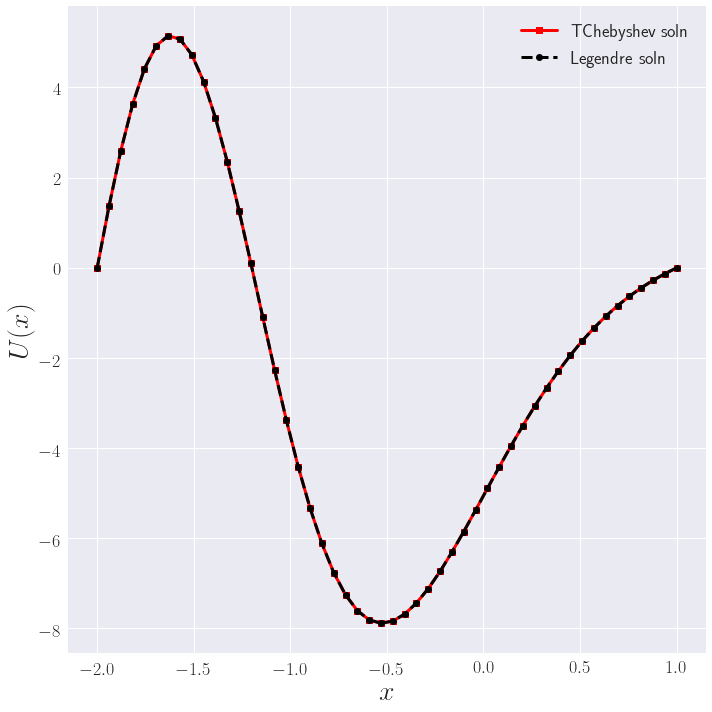

In [22]:
sample_q2d_2 = q2d_2()
sample_q2d_2.get_soln_plot(save=True)